In [1]:
import sys
sys.path.append('../../lib/')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from scipy.stats import linregress
from jax.example_libraries.optimizers import adamax, pack_optimizer_state, unpack_optimizer_state
from hetero_simulation.archive.agent import ces_utility, log_utility
from hetero_simulation.ml.utils import *
from hetero_simulation.econ_models.krusell_smith_discrete import neural_network, prices, fischer_burmeister, next_state, batch_loss, simulate_state_forward, training_loop
from hetero_simulation.econ_models.krusell_smith_discrete import params0, config, n, mb, k, m, nn_shapes, generate_random_state, n_forward, n_epoch

jax.config.update('jax_platform_name', 'cpu')

In [32]:
def ces_utility(sigma):
    return jax.jit(
        lambda c: jax.lax.select(
            sigma == 1.,
            jnp.log(c),
            jnp.power(jnp.sum(jnp.power(c, ((sigma - 1)/sigma))), (sigma/(sigma - 1)))
        )
    )

print(jax.grad(ces_utility(2.))(2.))
print(jax.grad(ces_utility(1.))(2.))

0.99999994


ZeroDivisionError: float division by zero

In [2]:
TRAIN_MORE = False

In [17]:
saved_state = pickle.load(open(f'../models/ks_disc_model_prefhet_{k}_final.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_state)
_, _, get_params = adamax(step_size=0.01)
if TRAIN_MORE:
    opt_state = training_loop(opt_state, max_iter=2500)
params = get_params(opt_state)
    
key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))
Xs, Zs, Es, key = generate_random_state(params, config, key, n_forward=100)

### Assumed Parameter Values

In [4]:
config

{'alpha': 0.36,
 'beta': 0.96,
 'delta': 0.025,
 'sigma_z': 0.01,
 'sigma_e': DeviceArray(0.08717798, dtype=float32, weak_type=True),
 'rho_z': 0.95,
 'rho_e': 0.9,
 'discrete': False}

As in MMW, both aggregate productivity and idiosyncratic productivity are assumed to follow an AR(1) process, with parametes rho_z/e and sigma_z/e respectively. This is a deviation from the original Krusell-Smith, in which these follow a joint, discrete, first order Markov process.

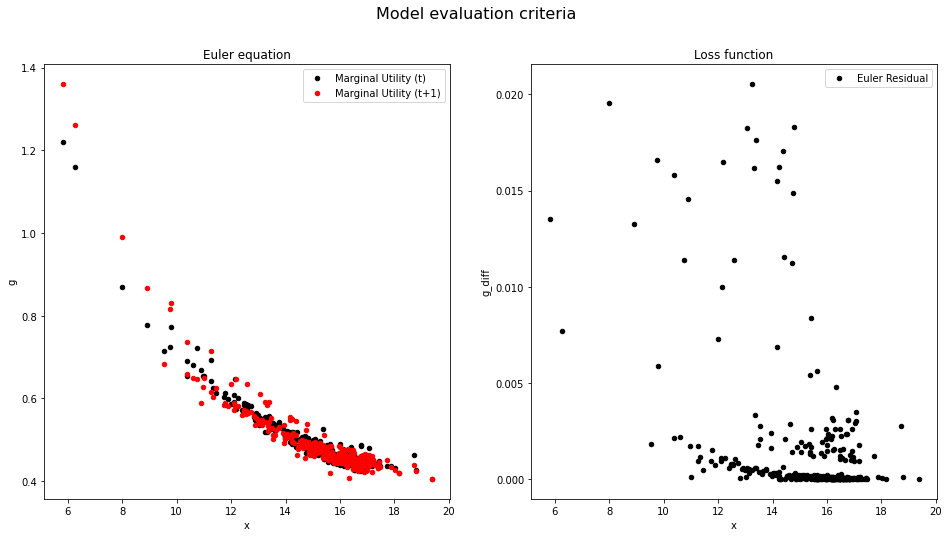

In [18]:
keys = jax.random.split(key, Xs.shape[0])
u = log_utility()

Z1s, E1s = jax.vmap(next_state)(Zs, Es, keys)
Rs, Ws = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(Xs, Zs, Es)
ws = jax.vmap(lambda X, E, R, W: jax.vmap(lambda x, e: (R * x) + (W * e))(X, E))(Xs, Es, Rs, Ws)
outputs = jax.vmap(lambda X, Z, E, w: jax.vmap(lambda i: neural_network(params, X, E, Z, E[i], w[i]))(jnp.arange(k)))(Xs, Zs, Es, ws)
cs = outputs[..., 0]
lms = outputs[..., 1]
c_rels = cs / ws
X1s = ws - cs
R1s, W1s = jax.vmap(lambda X, Z, E: prices(config, X, Z, E))(X1s, Z1s, E1s)
w1s = jax.vmap(lambda X, E, R, W: jax.vmap(lambda x, e: (R * x) + (W * e))(X, E))(X1s, E1s, R1s, W1s)
c1s = jax.vmap(lambda X, Z, E, w: jax.vmap(lambda i: neural_network(params, X, E, Z, E[i], w[i])[0])(jnp.arange(k)))(X1s, Z1s, E1s, w1s)

u = lambda c: log_utility()(c)
gs = jax.vmap(lambda R, cs: jax.vmap(lambda c: config['beta'] * R * jax.grad(u)(c))(cs))(R1s, c1s)
ups = jax.grad(u)(cs)
us = jax.vmap(jax.vmap(u))(cs)

g_diff = (jax.vmap(lambda g, up, lm: (g/up - lm))(gs.reshape(-1, 1), ups.reshape(-1, 1), lms.reshape(-1, 1)))**2

df = pd.DataFrame(jnp.concatenate([ws.reshape(-1, 1), jnp.repeat(Zs, k).reshape(-1, 1), Es.reshape(-1, 1), 
                                   w1s.reshape(-1, 1),
                                   gs.reshape(-1, 1), c_rels.reshape(-1, 1),
                                   cs.reshape(-1, 1), us.reshape(-1, 1), ups.reshape(-1, 1),
                                   g_diff.reshape(-1, 1), lms.reshape(-1, 1)], axis=1))
df.columns = ['x', 'Z', 'e', 'x_prime', 'g', 'c_star_rel', 'c_star', 'u', 'u_prime', 'g_diff', 'lms']

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
df['gf'] = df['g'] - df['u_prime']
df.plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes[0])
df.plot(x='x', y='g', kind='scatter', color='red', ax=axes[0])
df.plot(x='x', y='g_diff', kind='scatter', color='black', ax=axes[1])

_ = fig.suptitle(f'Model evaluation criteria', fontsize=16)
_ = axes[0].set_title('Euler equation')
_ = axes[1].set_title('Loss function')
_ = axes[0].legend(labels=['Marginal Utility (t)', 'Marginal Utility (t+1)'])
_ = axes[1].legend(labels=['Euler Residual', 'Fischer-Burmeister'])

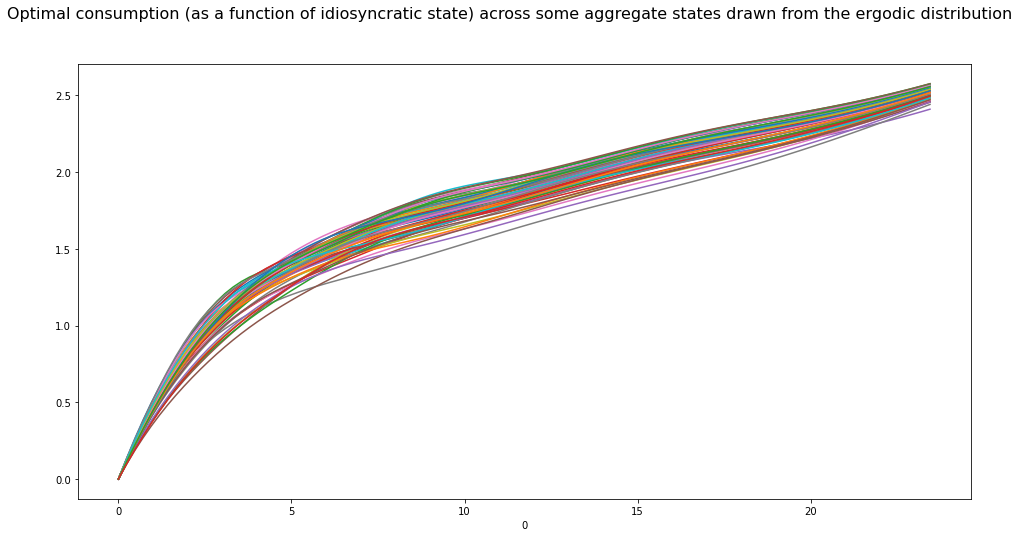

In [14]:
# X = jnp.multiply(jnp.ones((10, 5)), jnp.linspace(0, jnp.max(ws), 10).reshape(10, 1))
# Z = jax.random.choice(key, jnp.array([0.99, 1.01]), shape=(10, 1))
# E = jax.random.choice(key, jnp.array([0, 1]), p=jnp.array([0.2, 0.8]), shape=(10, 5))
idx = jax.random.choice(jax.random.PRNGKey(1), jnp.arange(Xs.shape[0]), shape=(10,), replace=False)
X = Xs
Z = Zs
E = Es
e = E[:, 1]

x_range = jnp.linspace(0, jnp.max(ws), 100)
c_range = jax.vmap(lambda X, E, Z, e: jax.vmap(lambda x: neural_network(params, X, E, Z, e, x)[0])(x_range))(X, Z, E, e)
data = pd.DataFrame(jnp.concatenate((x_range.reshape(-1, 1), c_range.T), axis=1))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
_ = data.plot(x=0, y=jnp.arange(Xs.shape[0]) + 1, ax=ax, legend=False)
_ = fig.suptitle(f'Optimal consumption (as a function of idiosyncratic state) across some aggregate states drawn from the ergodic distribution', fontsize=16)

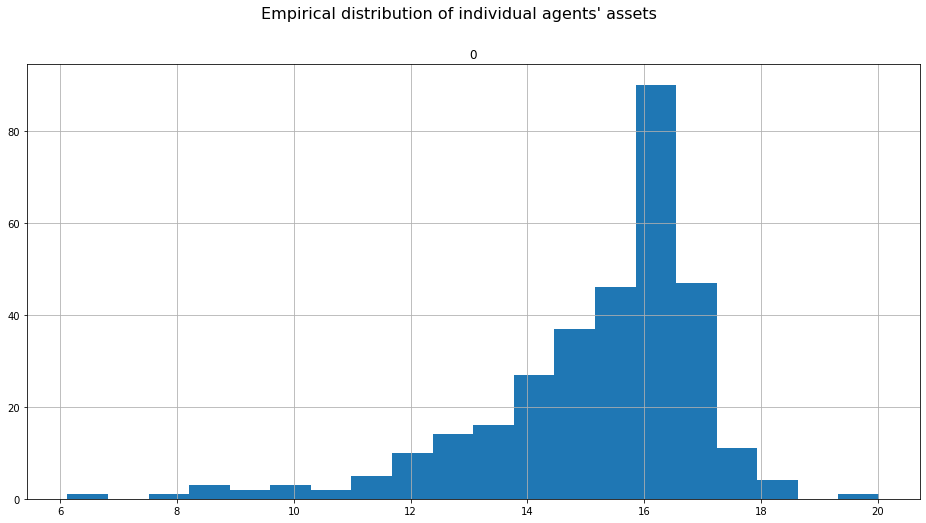

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
_ = pd.DataFrame(ws.reshape(-1, 1)).hist(ax=ax, bins=20)
_ = fig.suptitle(f'Empirical distribution of individual agents\' assets', fontsize=16)

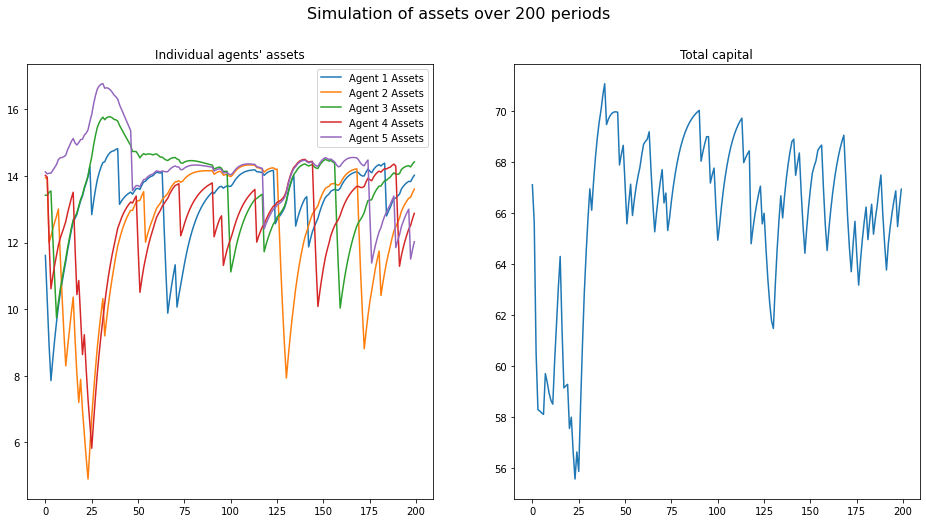

In [19]:
n_periods = 200
X_range = Xs[jnp.newaxis, ...]
Z_range = Zs[jnp.newaxis, ...]
E_range = Es[jnp.newaxis, ...]
for i in range(n_periods - 1):
    Xs, Zs, Es, key = simulate_state_forward(params, config, Xs, Zs, Es, key, 1)
    X_range = jnp.concatenate((X_range, Xs[jnp.newaxis, ...]))
    Z_range = jnp.concatenate((Z_range, Zs[jnp.newaxis, ...]))
    E_range = jnp.concatenate((E_range, Es[jnp.newaxis, ...]))

states = pd.DataFrame(jnp.concatenate((X_range[:, 1, :], Z_range[:, 1][:, jnp.newaxis], E_range[:, 1, :]), axis=1))
agg_states = pd.DataFrame(jnp.sum(X_range[:, 1, :], axis=1))
states = pd.concat((states, agg_states), axis=1)
states.columns = [f'Agent {i+1} Assets' for i in range(k)] +\
                 [f'Aggregate Productivity'] +\
                 [f'Agent {i+1} Employment' for i in range(k)] +\
                 ['Total Assets in Economy']
states['Total Employment'] = states[[f'Agent {i + 1} Employment' for i in range(k)]].sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
_ = states.plot(y=[f'Agent {i+1} Assets' for i in range(k)], ax=axes[0])
_ = states.plot(y=['Total Assets in Economy'], ax=axes[1], legend=False)
_ = fig.suptitle(f'Simulation of assets over {n_periods} periods', fontsize=16)
_ = axes[0].set_title(f'Individual agents\' assets', fontsize=12)
_ = axes[1].set_title(f'Total capital', fontsize=12)

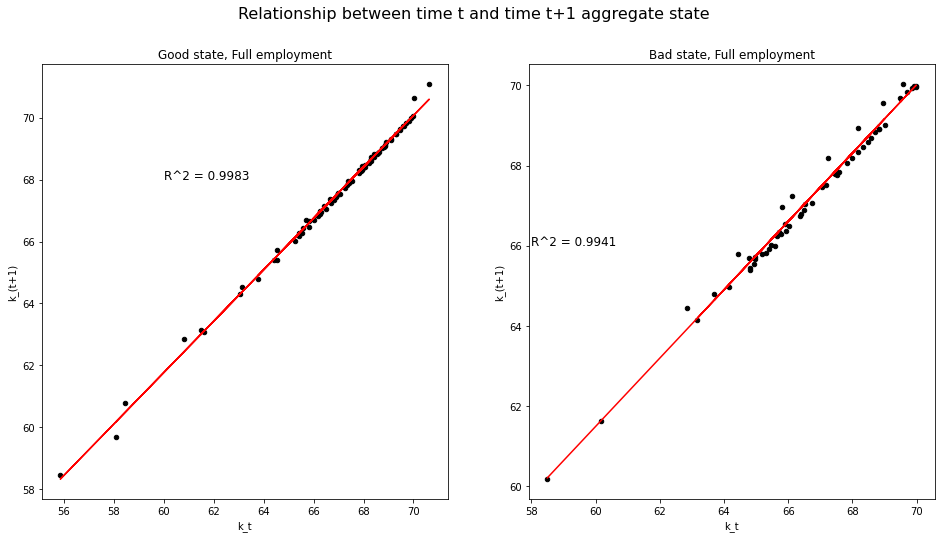

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
agg_assets = pd.concat((agg_states, agg_states.shift(-1), states['Aggregate Productivity'], states['Total Employment']), axis=1).dropna()
agg_assets.columns = ['k_t', 'k_(t+1)', 'Z_t', 'E_t']
agg_assets_g = agg_assets[(agg_assets['Z_t'] == 1.01) & (agg_assets['E_t'] == 5.0)].copy()
agg_assets_b = agg_assets[(agg_assets['Z_t'] == 0.99) & (agg_assets['E_t'] == 5.0)].copy()

# m, b, r2, p, e = linregress(agg_assets_g['E_t'], agg_assets_g['k_(t+1)'])
# agg_assets_g['k_(t+1)'] = agg_assets_g['k_(t+1)'] - (m * agg_assets_g['E_t'] + b)

m, b, r2, p, e = linregress(agg_assets_g['k_t'], agg_assets_g['k_(t+1)'])
x = np.linspace(agg_assets_g['k_t'].min(), agg_assets_g['k_(t+1)'].max(), 100)
agg_assets_g['reg_line'] = m * agg_assets_g['k_t'] + b
agg_assets_g.plot(x='k_t', y='k_(t+1)', kind='scatter', ax=axes.flatten()[0], color='black')
agg_assets_g.plot(x='k_t', y='reg_line', kind='line', ax=axes.flatten()[0], color='red', legend=False)
_ = axes.flatten()[0].annotate(f'R^2 = {r2:.4f}', (60, 68), fontsize=12)
axes.flatten()[0].set_title('Good state, Full employment')

# m, b, r2, p, e = linregress(agg_assets_b['E_t'], agg_assets_b['k_(t+1)'])
# agg_assets_b['k_(t+1)'] = agg_assets_b['k_(t+1)'] - (m * agg_assets_b['E_t'] + b)

m, b, r2, p, e = linregress(agg_assets_b['k_t'], agg_assets_b['k_(t+1)'])
x = np.linspace(agg_assets_b['k_t'].min(), agg_assets_b['k_(t+1)'].max(), 100)
agg_assets_b['reg_line'] = m * agg_assets_b['k_t'] + b
agg_assets_b.plot(x='k_t', y='k_(t+1)', kind='scatter', ax=axes.flatten()[1], color='black')
agg_assets_b.plot(x='k_t', y='reg_line', kind='line', ax=axes.flatten()[1], color='red', legend=False)
_ = axes.flatten()[1].annotate(f'R^2 = {r2:.4f}', (58, 66), fontsize=12)
axes.flatten()[1].set_title('Bad state, Full employment')

_ = fig.suptitle(f'Relationship between time t and time t+1 aggregate state', fontsize=16)

In [4]:
from hetero_simulation.econ_models.krusell_smith_discrete import batch_loss
opt_init, opt_update, get_params = adamax(step_size=0.001)
opt_state = opt_init(params)

for i in range(30000):
    for j in range(2 * (n // mb)):
        keys = jax.random.split(key, 2)
        key = keys[-1]
        sample = jax.random.choice(jax.random.PRNGKey(j * i), jnp.arange(n), shape=(mb,))
        params = get_params(opt_state)
        grad = jax.grad(batch_loss, has_aux=True)(params, config, Xs[sample], Zs[sample], Es[sample], keys)[0]
        opt_state = opt_update(i * (2 * (n // mb)) + j, grad, opt_state)

    params = get_params(opt_state)
    if n_forward > 0:
        Xs, Zs, Es, key = simulate_state_forward(params, config, Xs, Zs, Es, key, n_forward)

    if i % 100 == 0:
        val, grad = jax.value_and_grad(batch_loss, has_aux=True)(params, config, Xs, Zs, Es, keys)
        val_loss = jnp.abs(val[0])
        print(f'Iteration: {i}\tTotal Loss: {val_loss:2.2e}' +\
              f'\tMax Grad: {max([jnp.max(jnp.abs(v)) for k, v in grad.items()]):2.2e}')

Iteration: 0	Total Loss: 7.26e-05	Max Grad: 1.14e-02
Iteration: 100	Total Loss: 1.69e-06	Max Grad: 6.86e-04
Iteration: 200	Total Loss: 7.31e-07	Max Grad: 2.79e-03
Iteration: 300	Total Loss: 4.47e-05	Max Grad: 1.52e-02
Iteration: 400	Total Loss: 1.15e-06	Max Grad: 6.02e-03
Iteration: 500	Total Loss: 1.28e-05	Max Grad: 6.79e-03
Iteration: 600	Total Loss: 2.47e-05	Max Grad: 1.31e-02
Iteration: 700	Total Loss: 6.34e-06	Max Grad: 4.49e-03
Iteration: 800	Total Loss: 9.33e-06	Max Grad: 4.96e-03
Iteration: 900	Total Loss: 3.01e-05	Max Grad: 3.18e-03
Iteration: 1000	Total Loss: 1.20e-05	Max Grad: 3.77e-03
Iteration: 1100	Total Loss: 4.82e-06	Max Grad: 4.99e-03
Iteration: 1200	Total Loss: 1.05e-05	Max Grad: 4.37e-03
Iteration: 1300	Total Loss: 2.20e-05	Max Grad: 2.73e-03
Iteration: 1400	Total Loss: 5.95e-05	Max Grad: 1.93e-02
Iteration: 1500	Total Loss: 1.98e-05	Max Grad: 1.01e-02
Iteration: 1600	Total Loss: 1.57e-05	Max Grad: 6.00e-03
Iteration: 1700	Total Loss: 1.03e-05	Max Grad: 5.75e-03
Iter

KeyboardInterrupt: 